# Particle movement in a simple model of a tokamak

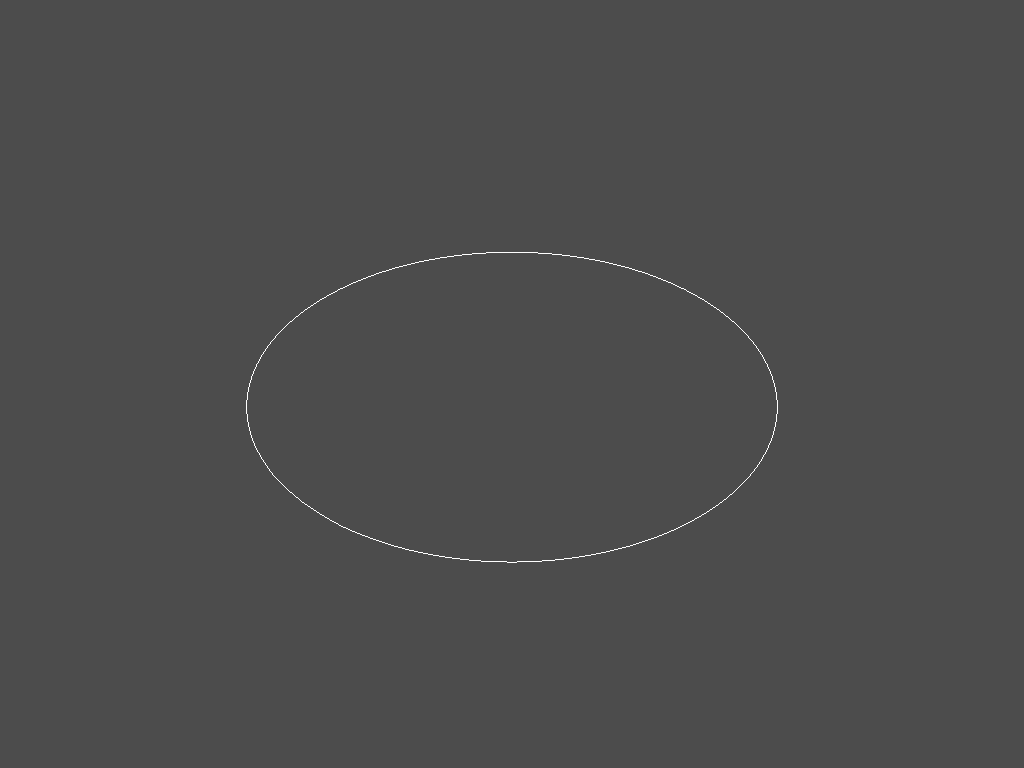

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [1]:
%autoreload 2
from plasmapy import simulation
from plasmapy.formulary import magnetostatics
from plasmapy.classes.sources import Coils
import astropy.units as u
import numpy as np
radius = 0.5 * u.m
main_current = 4 * u.kA
plasma_wire = magnetostatics.CircularWire([0, 0, 1], u.Quantity((0, 0, 0), u.m), radius, main_current)
plasma_wire.visualize()

That's supposed to model just the plasma; let's add a few coils:

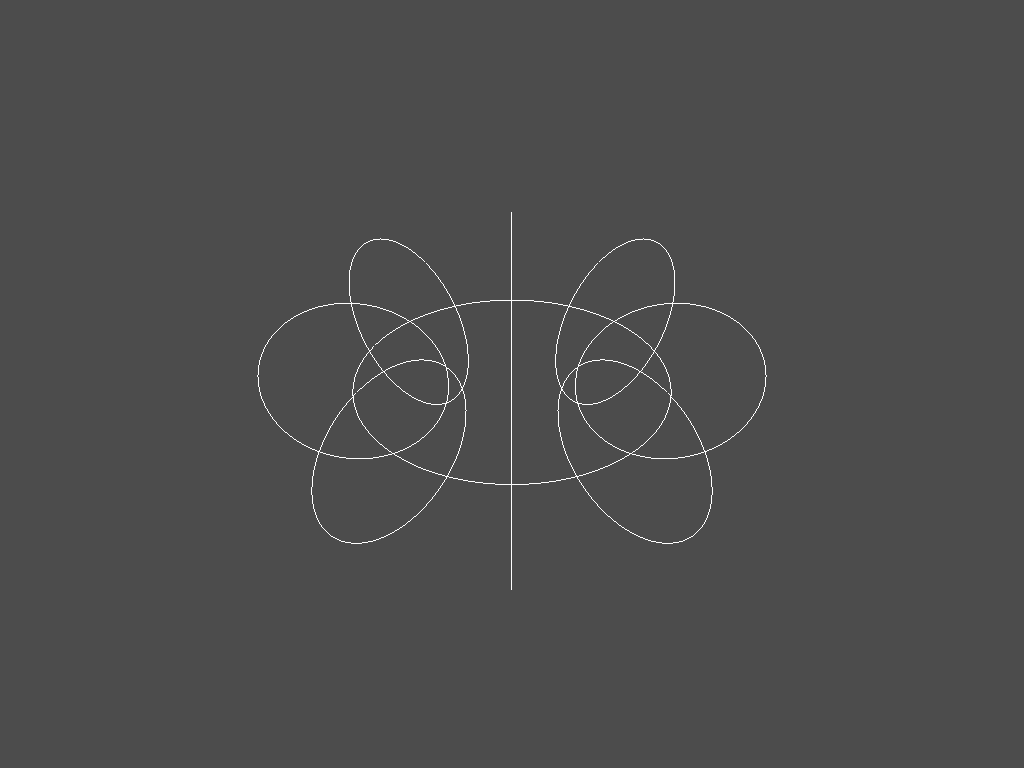

In [2]:
n_coils = 8
currents = n_coils * [4 * u.kA]

coil_angles = np.linspace(0, 2*np.pi, n_coils, endpoint=False)
coil_angles
minor_radius = 0.3 * u.m

coils = []
for i in range(n_coils):
    coil_angle = coil_angles[i]
    x = radius * np.cos(coil_angle)
    y = radius * np.sin(coil_angle)
    normal_angle = np.pi/2 + coil_angle
    normal = u.Quantity([np.cos(normal_angle), np.sin(normal_angle), 0])
    center = u.Quantity([x, y, 0 * u.m])
    coil = magnetostatics.CircularWire(normal, center, minor_radius, currents[i])
    coils.append(coil)
all_currents = coils + [plasma_wire]
c = Coils(*all_currents)
c.visualize()

Note that a shortcut for this model can be quickly accessed as `Coils.toykamak`.

Let's add a proton. We'll put it at $x = 0.6 \text{m}$, directly in the central YZ plane, and we'll give it a very nonrelativistic velocity of 300m/s in the Y direction.

In [24]:
x = u.Quantity([[0.6, 0, 0]],  u.m)
v = u.Quantity([[0, 300, 0]], u.m / u.s)

initial_condition = simulation.ParticleTracker(c, x, v, 'p',)
initial_condition

ParticleTracker(plasma=<plasmapy.classes.sources.coils.Coils object at 0x7fdf0d3faa60>, particle_type=p+, N = 1)

Let's run the simulation for 0.1s. We'll use a timestep of $10 \mu \text{s}$.

In [25]:
solution = initial_condition.run(1e-1 * u.s, dt = 1e-5 * u.s)
solution

<xarray.Dataset>
Dimensions:         (dimension: 3, particle: 1, time: 1001)
Coordinates:
  * time            (time) float64 0.0 0.00011 0.00021 ... 0.09981 0.09991 0.1
  * particle        (particle) int64 0
  * dimension       (dimension) <U1 'x' 'y' 'z'
Data variables:
    position        (time, particle, dimension) float64 0.6 0.0 ... -0.03678
    velocity        (time, particle, dimension) float64 -64.52 217.3 ... -86.12
    B               (time, particle, dimension) float64 1.084e-19 ... -0.004752
    E               (time, particle, dimension) float64 0.0 0.0 0.0 ... 0.0 0.0
    timestep        (time) float64 1e-05 1e-05 1e-05 1e-05 ... 1e-05 1e-05 1e-05
    kinetic_energy  (time, particle) float64 7.527e-23 7.527e-23 ... 7.527e-23
Attributes:
    particle:          p+
    total_iterations:  10001

The result is an `xarray.Dataset`. We can visualize the simulation using methods in the `particletracker` xarray accessor, which should be getting registered on using anything from the `particletracker` module:

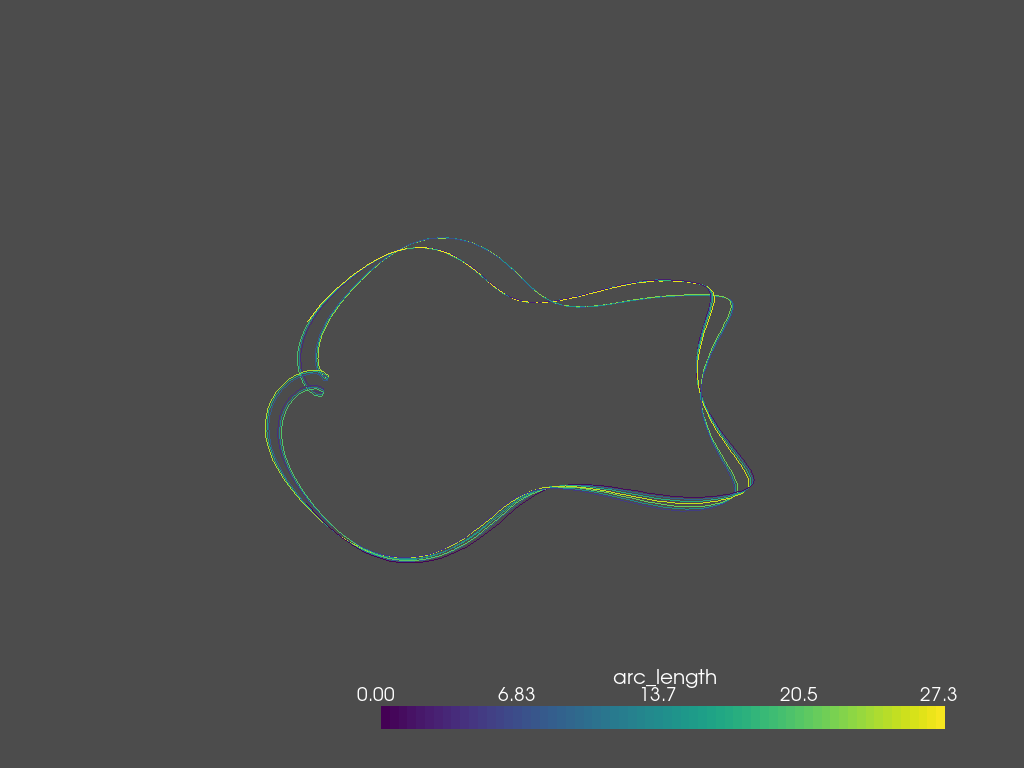

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [31]:
solution.particletracker.visualize().show()

We can also pass the plasma to the visualizer to see where the trajectory is relative to the coils:

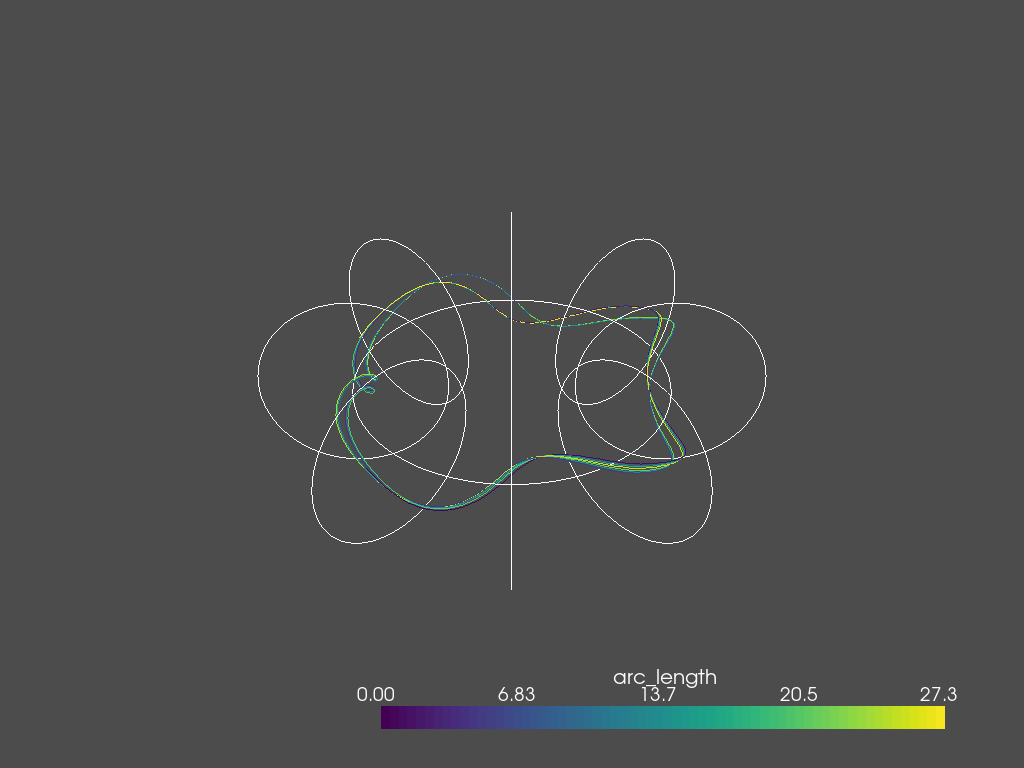

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [32]:
solution.particletracker.visualize(plasma=c).show()

We can also animate this motion, save it to MP4 and display it within the notebook. Depending on the number of frames in your simulation, this might take a while.

Note how the particle's velocity vector wobbles - it's the gyroorbit precession! (I think.)

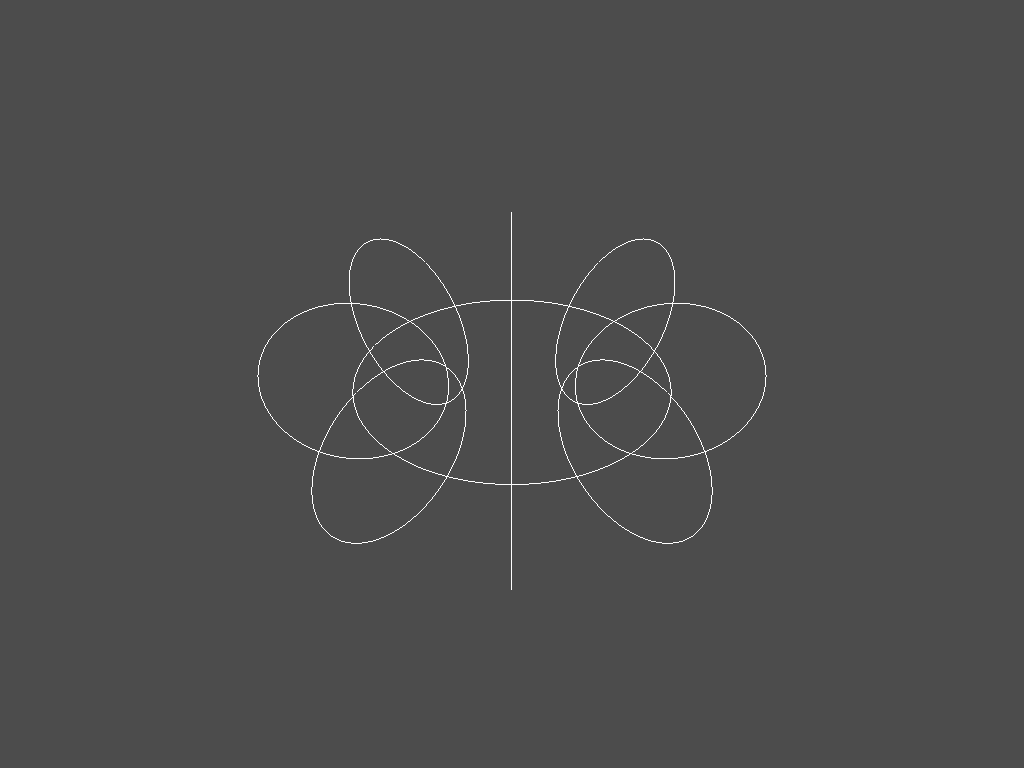

In [33]:
solution.particletracker.animate("toykamak.mp4", nframes = 1000, notebook_display = True, plasma=c)

Since the solution is an `xarray`, we can use the usual `xarray` syntax. The `particletracker` accessor also contains a helpful `vector_norm` method:

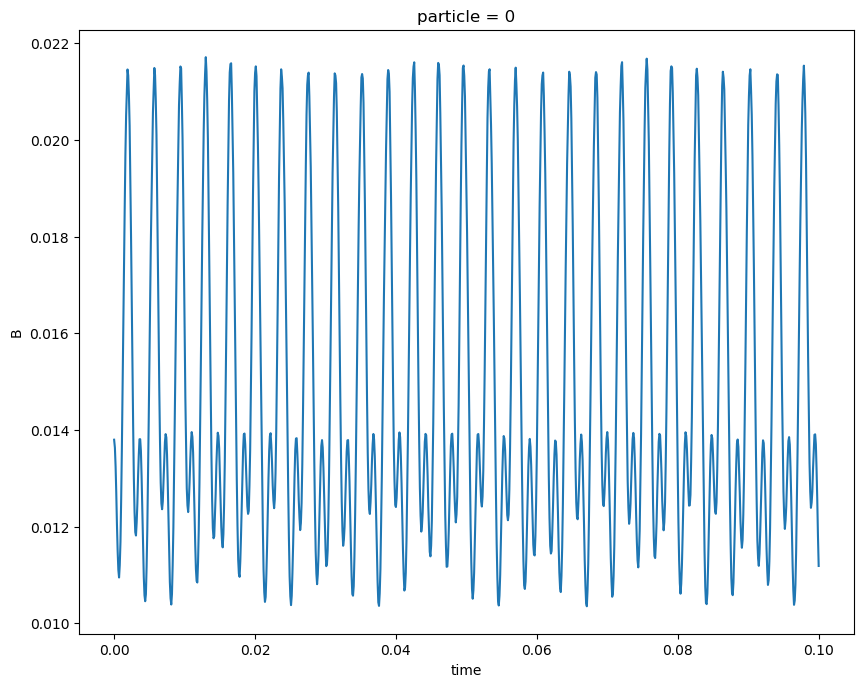

In [34]:
solution.sel(particle=0).particletracker.vector_norm('B', 'dimension').plot.line();

Let's take a look at the same trajectory for an electron. Since timescales for electrons will generally be shorter than for protons, we'll adjust and take more snapshots.

In [35]:
solution_electron = simulation.ParticleTracker(c, x, v, 'e-').run(1 * u.s, dt = 1e-5 * u.s, snapshot_steps = 10000)

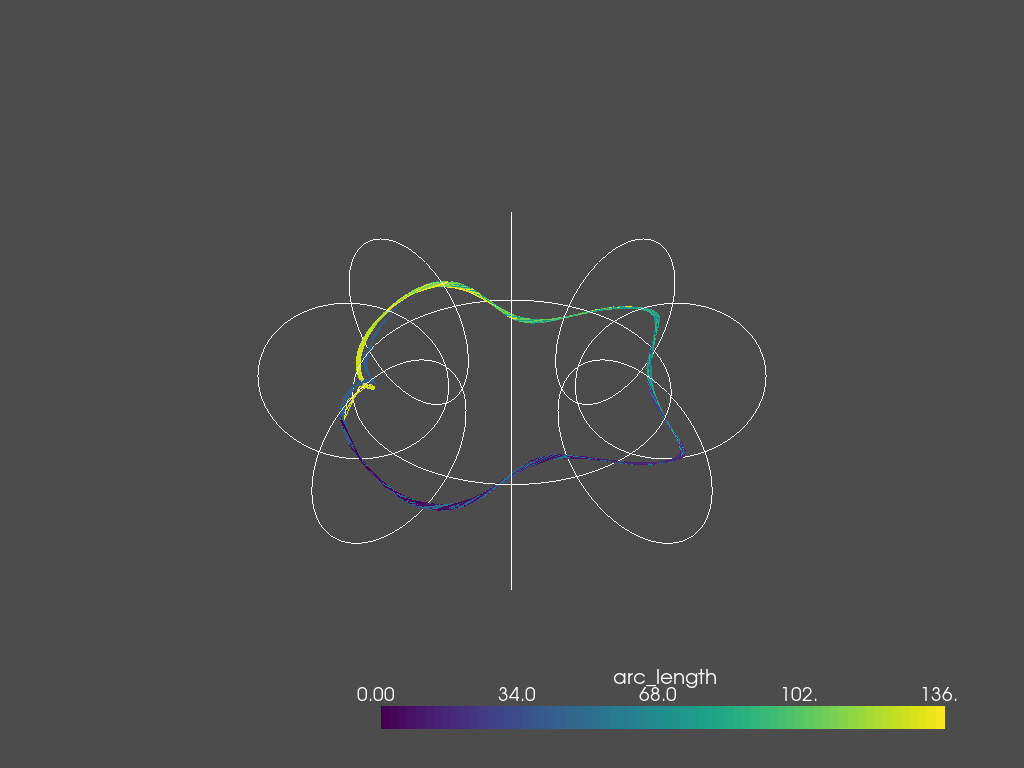

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [36]:
solution_electron.particletracker.visualize(plasma=c, stride=2).show()

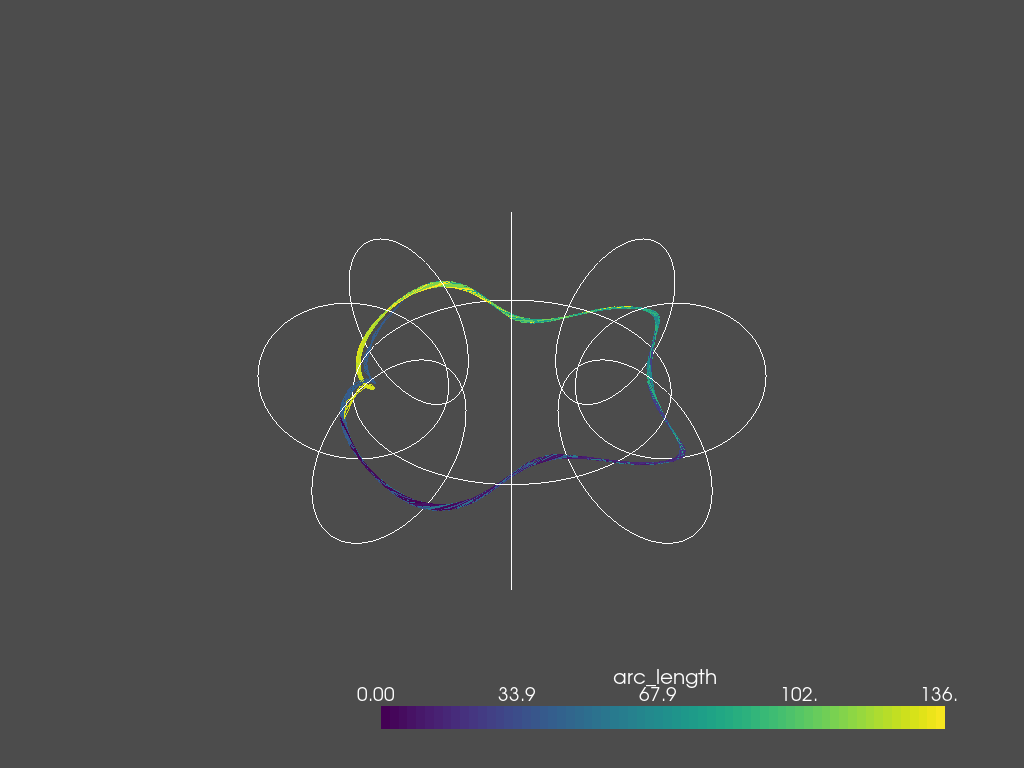

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [38]:
solution_electron.particletracker.visualize(plasma=c).show()

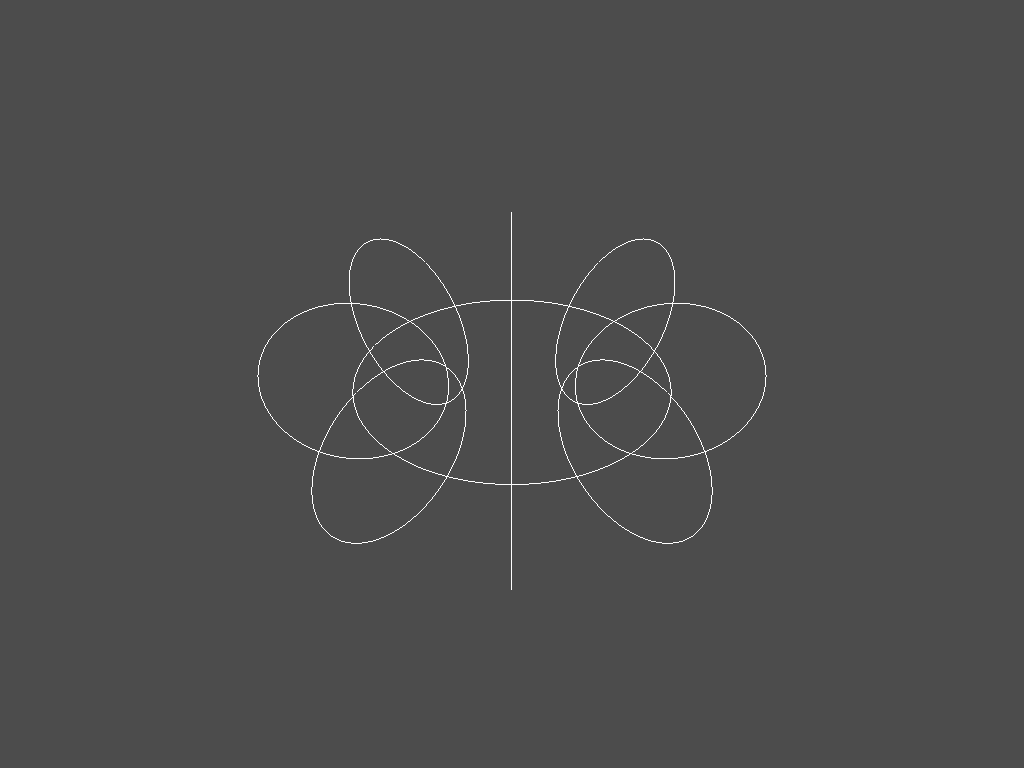

In [37]:
solution.particletracker.animate("toykamak_electron.mp4", solution.particle, nframes = 1000, notebook_display = True, plasma=c)

We also have a bunch of other solvers:

In [43]:
for name, integrator in simulation.ParticleTracker.integrators.items():
    print(name)
    print(integrator.__doc__)

explicit_boris

    Implement the explicit Boris pusher for moving and accelerating particles.

    Arguments
    ----------
    init : bool (optional)
        If `True`, does not change the particle positions and sets dt
        to -dt/2.

    Notes
    ----------
    The Boris algorithm is the standard energy conserving algorithm for
    particle movement in plasma physics. See [1]_ for more details.

    Conceptually, the algorithm has three phases:

    1. Add half the impulse from electric field.
    2. Rotate the particle velocity about the direction of the magnetic
       field.
    3. Add the second half of the impulse from the electric field.

    This ends up causing the magnetic field action to be properly
    "centered" in time, and the algorithm conserves energy.

    References
    ----------
    .. [1] C. K. Birdsall, A. B. Langdon, "Plasma Physics via Computer
           Simulation", 2004, p. 58-63
    
implicit_boris

    Implement the implicit Boris pusher for moving 

Besides the default `explicit_boris`, they have varying levels of usefulness and especially stability right now:

explicit_boris


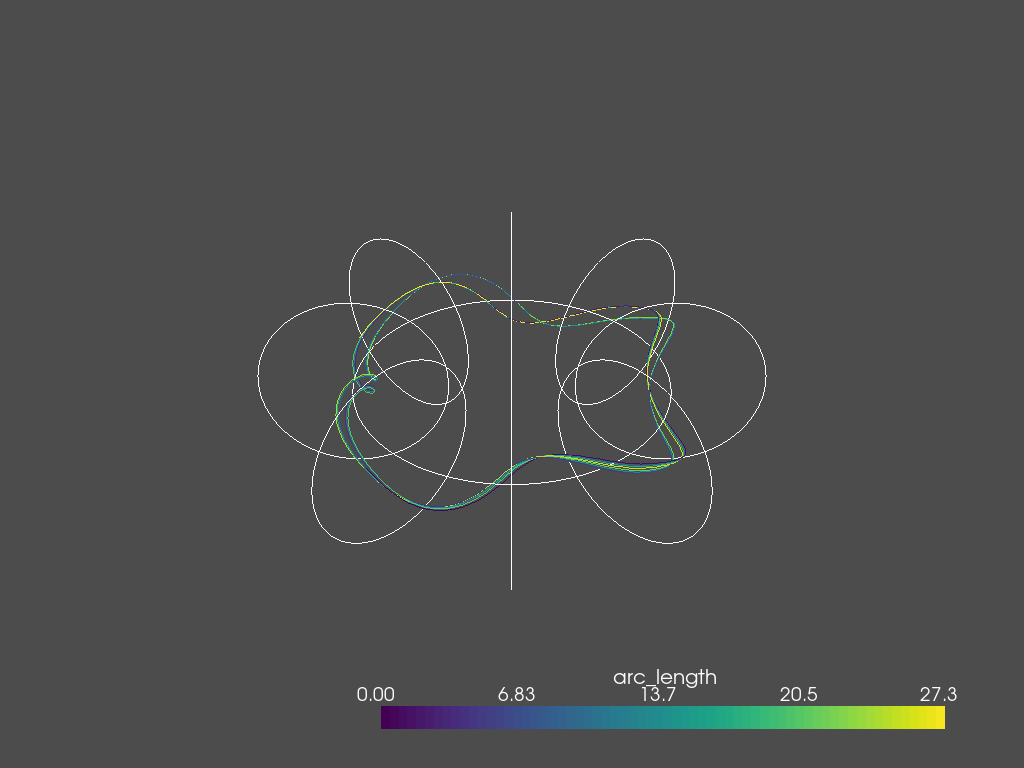

ERROR:root:The interactor must be set prior to enabling/disabling widget


implicit_boris


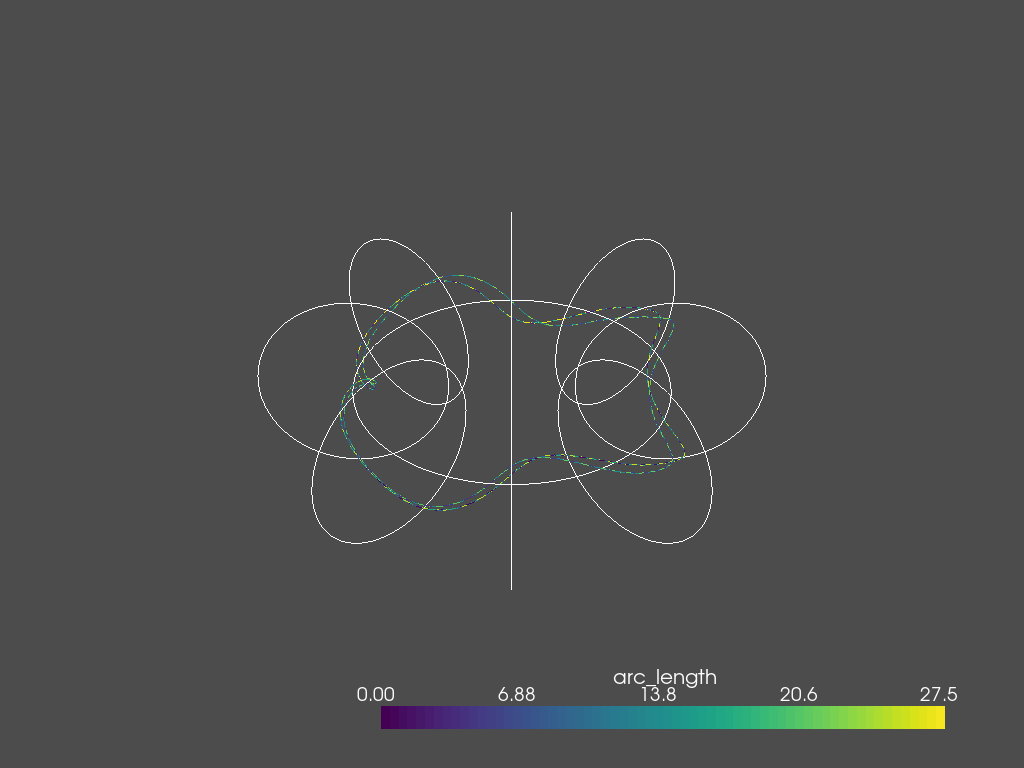

ERROR:root:The interactor must be set prior to enabling/disabling widget


implicit_boris2


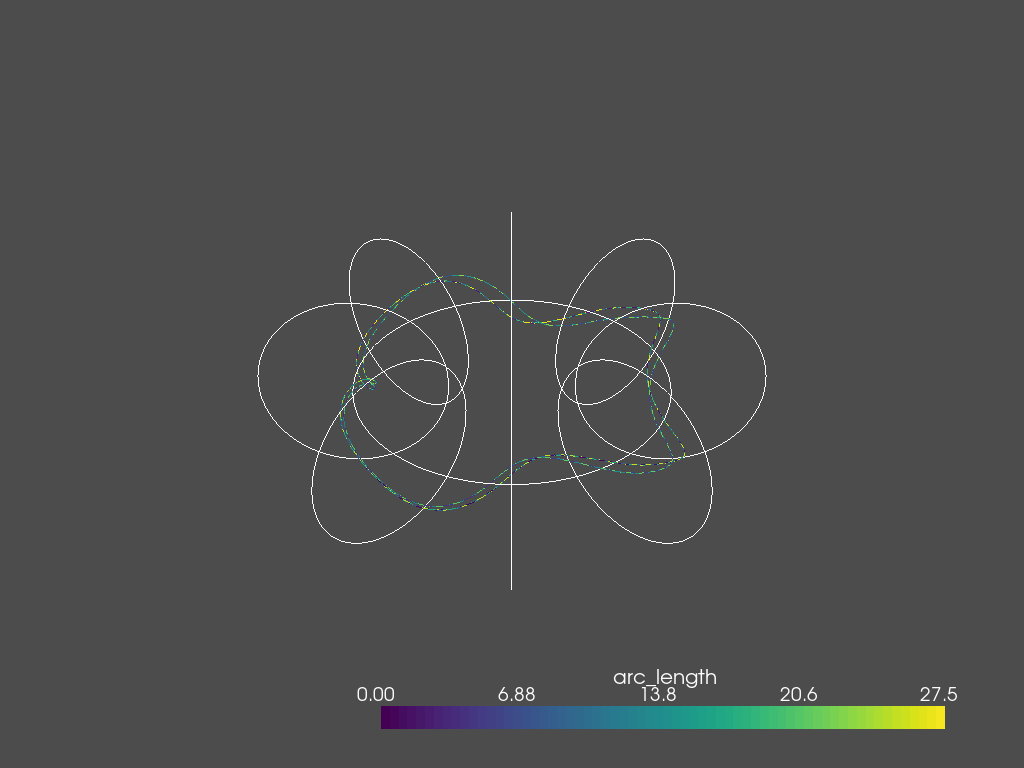

ERROR:root:The interactor must be set prior to enabling/disabling widget


zenitani


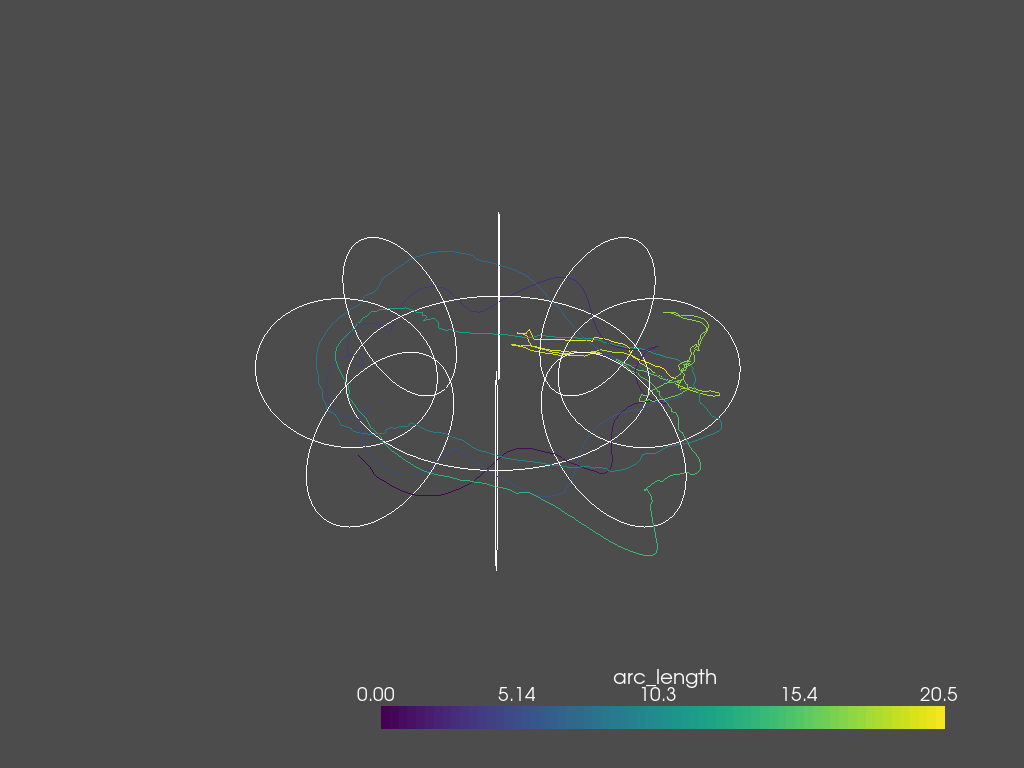

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [49]:
for name, integrator in simulation.ParticleTracker.integrators.items():
    print(name)
    solution = initial_condition.run(1e-1 * u.s, 1e-5 * u.s, pusher=name)
    solution.particletracker.visualize(plasma=c).show()

In [ ]:
N = 10
x = u.Quantity(np.zeros((N, 3)),  u.m)
x[:,0] = 0.6 * u.m
v = u.Quantity(np.zeros((N, 3)), u.m / u.s)
v[:,1] = 300 * u.m / u.s
np.random.seed(0)
v[:,0] = np.random.normal(size=N) * u.m / u.s
v[:,2] = np.random.normal(size=N) * u.m / u.s

simulation_multiple = simulation.ParticleTracker(c, x, v, 'p').run(1e-1 * u.s, 1e-5 * u.s, pusher=name)

In [ ]:
simulation_multiple.particletracker.visualize(plasma=c)

In [ ]:
simulation_multiple.particletracker.animate("toykamak_electron.mp4", solution.particle, nframes = 1000, notebook_display = True, plasma=c)